## Analysis of five different newspapers on their coverage of the Russia-Ukraine conflict ##

**Anthony Cooper**
* [Introduction](#introduction)
* [Importing libraries](#importing-libraries)
* [Importing data and EDA](#import-data-and-eda)
* [Sentiment analysis](#sentiment-analysis)
* [Class TF-IDF](#class-tf-idf)
* [Classification modeling](#modeling)
* [Conclusions](#conclusion)

## Introduction ##

### The Russia-Ukraine conflict ###

Conflict between Ukraine and Russia is not a new phemonemon and has been ongoing for the past eight years since Russia seized Crimea.  However, on 24 Feburary 2022, Russia began an invasion of Ukraine.  Russia's goal is simple, bring Ukraine back into the Russian fold through the liberation of the Ukranian people from Western-aligned government of Volodymyr Zelenskyy.

As a result, the majority of Western nations denounced Putin's actions and imposed sanctions on Russia.  It's clear how the governments of Western countries think about this conflict, but it is less clear how different news outlets cover this conflict.  The purpose of this study is to attempt to understand the differences between five different newspapers' treatment of the conflict through analyzing the keywords and performing sentiment analysis on each newspaper, and then constructing a model to classify articles based on the newspaper they are from.

### Choosing newspapers to study ###

Newspapers were chosen to represent a diverse spectrum of political opinion: 
* **Fox News** is a famous right-wing newspaper
* **CNN** is known for its left-wing politics
* **Reuters** is a relatively politically neutral newspaper
* **TASS** is one of Russia's leading news agency
* **Ukrinform** is the national news agency of Ukraine

This sample of newspapers is politically diverse including two newspapers with a bias to different sides.  

## Study outline ##

### Data collection ###

News articles were scraped from the web using a combination of scrapy, selenium, and [pygooglenews](https://github.com/kotartemiy/pygooglenews).  

### Analysis ###

In order to analyze the different articles we implement the following steps:

**1.** Preprocessing of the articles through tokenization, removing stop words, lemmatization, and a preliminary clean up of the text.

**2.** Exploring basic text data

**3.** Sentiment analysis

**4.** Uncovering key unigrams and bigrams

### Classification ###

We build a classification model using three methods:

1. **c-TF-IDF score similarity**
2. **XGBoost** (gradient boosting library)
3. **DNN**

<a id='importing_libraries'></a> 
## Importing libraries ##

In [41]:
# Imports
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('punkt')


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

import keras 
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence
from keras.layers.core import Dense, Activation, Dropout
import tensorflow as tf

import importlib
import itertools
import Preprocessing_and_utility as prep
importlib.reload(prep)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'Preprocessing_and_utility' from 'c:\\Users\\ajc34\\Documents\\Ukraine_Conflict_Analysis\\Preprocessing_and_utility.py'>

### Import data and EDA ###

In [3]:
articles = pd.read_csv('preprocessed_ukraine_war_news.csv')
# We filter out some irrelevant articles
articles = prep.filter_articles(articles)
articles.head()

,publish_date,content,newspaper
0,2022-05-22 00:00:00+00:00,service member pro russian troops stands guard...,reuters
1,2022-04-23 00:00:00+00:00,berlin april berlin pilecki institute dedicate...,reuters
2,2022-03-02 00:00:00+00:00,amsterdam march international criminal court i...,reuters
3,2022-09-16 00:00:00+00:00,tallinn sept top general friday said war crime...,reuters
4,2022-09-16 00:00:00+00:00,russian president vladimir putin indian prime ...,reuters


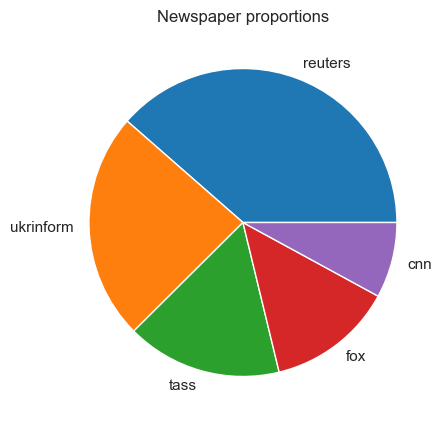

In [200]:
newspaper_counts = articles['newspaper'].value_counts()

sns.set_theme(style="white", palette=None)

plt.figure(figsize=(5,5))
plt.pie(newspaper_counts.values, labels=newspaper_counts.index)
plt.title('Newspaper proportions')
plt.show()


There is a slight imbalance in the distribution of newspapers, for example between Reuters and CNN, but not a severe imbalance so hopefully this doesn't impact our ability to classify.

In [201]:
# Convert to datetime to plot
articles['publish_date'] = pd.to_datetime(articles['publish_date'], format='%Y-%m-%d', utc=True)
# Let's focus only on dates from the beginning of the war (Feburary 20, 2022) to the end of September.
mask = (articles['publish_date'] > '2022-02-20') & (articles['publish_date'] < '2022-09-30')
articles = articles.loc[mask]

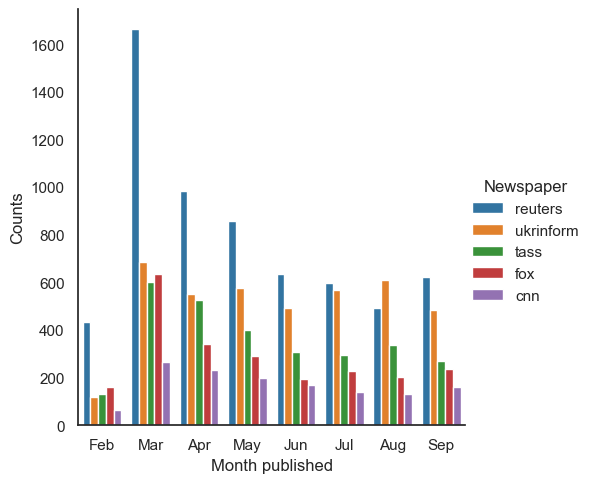

In [202]:
month_articles = articles.copy()

month_articles['Month published'] = articles['publish_date'].dt.month
month_articles['Newspaper'] = articles['newspaper']
numbered_month_articles = month_articles.copy()
month_articles['Month published'] = pd.to_datetime(month_articles['Month published'], format='%m').dt.month_name().str.slice(stop=3)

num_of_cnn = len(np.where(month_articles['Newspaper'] == 'cnn')[0])

x,y = 'Month published', 'Newspaper'
(month_articles
.groupby(x)[y]
.value_counts()
.rename('Counts')
.reset_index()
.pipe((sns.catplot, 'data'), x=x, y='Counts',hue=y,kind='bar',order=['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']))

#publish_date_counts = articles.groupby([articles['newspaper'], articles['publish_date'].dt.year, articles['publish_date'].dt.month])['publish_date'].count()
#sns.countplot(data=month_articles, x='Month published', hue='Newspaper', palette='bright')

#sum_of_articles = articles.groupby('newspaper').sum

**1.** Generally, the number of articles has decreased since the inception of the conflict.

**2.** Reuters has the most significant decrease while CNN and Ukrinform are more constant.  It makes sense for Ukrinform since it's reporting on it's own country's war, but for CNN it could be that I didn't scrape all possible articles earlier in the war.

Text(0.5, 0, 'Processed article lengths')

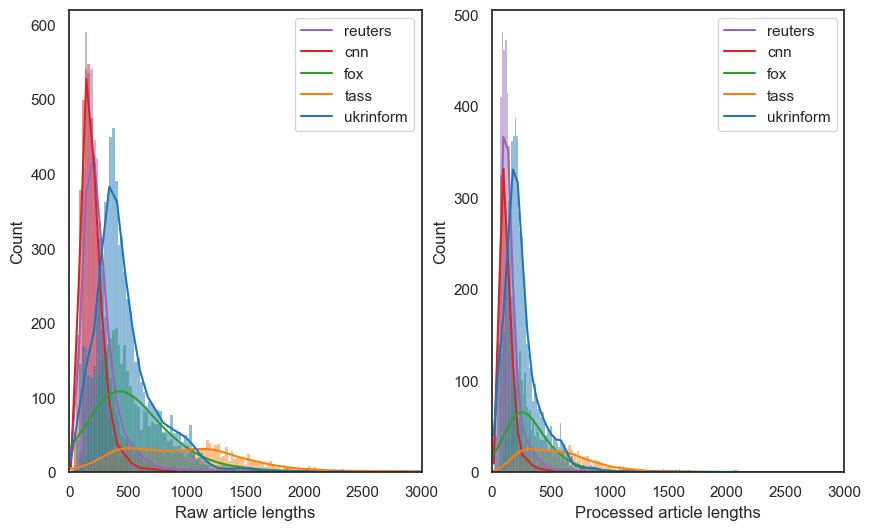

In [203]:
# To better understand the articles of each newspaper, we examine the distribution of article lengths
# We also compare the lengths of the raw vs preprocessed texts
raw_articles = pd.read_csv('ukraine_war_news.csv')
raw_text = raw_articles['content']
raw_text_lengths = [[len(text.split()) for text in raw_text[raw_articles['newspaper'] == newspaper]] for newspaper in raw_articles['newspaper'].unique()]

processed_text = articles['content']
processed_text_lengths = [[len(text.split()) for text in processed_text[articles['newspaper'] == newspaper]] for newspaper in articles['newspaper'].unique()]

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.histplot(raw_text_lengths, ax=axes[0], kde=True)
sns.histplot(processed_text_lengths, ax=axes[1], kde=True)

axes[0].legend(raw_articles['newspaper'].unique())
axes[0].set_xlim(0, 3000)
axes[0].set_xlabel('Raw article lengths')

axes[1].legend(raw_articles['newspaper'].unique())
axes[1].set_xlim(0, 3000)
axes[1].set_xlabel('Processed article lengths')

**1.** Most newspapers tend to have an average length of 500 words or less, however TASS has an extremely wide distribution of text lengths.  It's possible that some of the extremely long texts are aggregations of multiple articles, which is the case for the longest article in the dataframe.

**2.** Unsurprisingly, preprocessing roughly preserves the distribution of text lengths for each newspaper and also reduces the amount of outliers.

### Sentiment Analysis ###
In this section we strip down each article into purely positive and negative words to begin understanding how each newspaper differs in its coverage of the Ukraine conflict.  This is because we expect neutral words to be similar between the newspapers since the topic is the same.

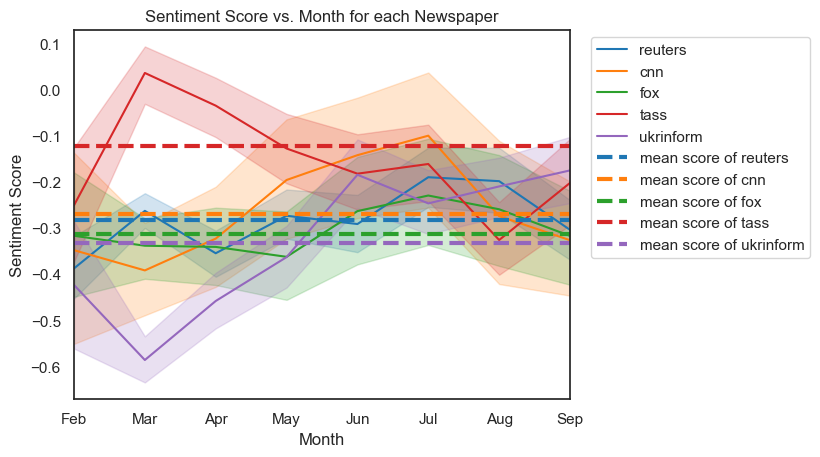

In [206]:
articles = prep.get_sentiment_score(articles)

articles['Month'] = articles['publish_date'].dt.month
american_articles = articles[(articles['newspaper'] != 'ukrinform') & (articles['newspaper'] != 'tass')]

ax = sns.lineplot(data=articles, x='Month', y='sentiment_score', hue='newspaper')
colors=sns.color_palette()[:5]

for ind, paper in enumerate(articles['newspaper'].unique()):
    mean = articles[articles['newspaper'] == paper]['sentiment_score'].mean()
    plt.axhline(mean, linestyle='--', linewidth=3, label="mean score of " + paper, color=colors[ind])

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score vs. Month for each Newspaper')
ax.set_xticks(range(2,10,1))
ax.set_xticklabels(['Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
ax.margins(x=0)


From looking at the above plot we can gain some important insights:

**1.** All the average sentiment scores are negative which is not surprising given that the coverage is about a war.

**2.** In the beginning we can see that TASS (biased towards Russia) articles exhibit an increasing sentiment score while the oppsite is true for Ukrinform (biased towards Ukraine), but over time we get a reversal.  These sentiment scores accurately reflect the state of the war since in the beginning Russia was gaining ground in Ukraine but over time suffered a lot of losses while Ukraine was holding its ground.

**3.** Reuters, Fox and CNN are relatively close in terms of sentiment.

To make it easier to see the differences between articles from newspapers from countries that are not engaged in the war with those that are, we separate them into two plots.

C:\Users\ajc34\AppData\Local\Temp\ipykernel_42748\1508599791.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])


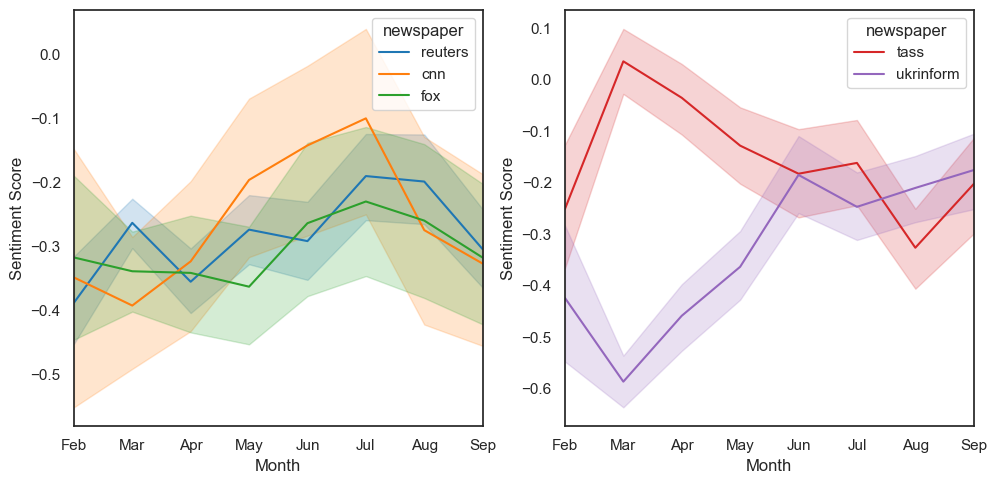

In [207]:

uninvolved_articles = articles[(articles['newspaper'] != 'ukrinform') & (articles['newspaper'] != 'tass')]
involved_articles = articles[(articles['newspaper'] == 'ukrinform') | (articles['newspaper'] == 'tass')]

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()

sns.lineplot(data=uninvolved_articles, ax=axes[0], x='Month', y='sentiment_score', hue='newspaper', palette=sns.color_palette()[:3])
sns.lineplot(data=involved_articles, ax=axes[1], x='Month', y='sentiment_score', hue='newspaper', palette=sns.color_palette()[3:5])
plt.tight_layout()

for ax in axes:
    ax.margins(x=0)
    ax.set_xticklabels(['Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
    ax.set_ylabel('Sentiment Score')



We now more clearly see that the variation in sentiment for Reuters, TASS and Ukrinform is relatively small, whereas the variation for Fox and CNN is quite large.  

This implies that knowing the month published and the sentiment of score of the article, we might be able to accurately classify the article as belonging to Reuters, TASS or Ukrinform but possibly not for Fox or CNN.

In [458]:
# To see how well each newspaper, month and sentiment score are correlated with each other, we need to one hot encode the newspaper column
transformer = make_column_transformer(
    (OneHotEncoder(), ['newspaper']),
    remainder='passthrough')

transformed = transformer.fit_transform(articles)
ohe_sent_articles = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)


for col in ohe_sent_articles.columns:
    ohe_sent_articles = ohe_sent_articles.rename(columns={col: col.split('__')[1]})
ohe_sent_articles.head()


,newspaper_cnn,newspaper_fox,newspaper_reuters,newspaper_tass,newspaper_ukrinform,publish_date,content
0,0.0,0.0,1.0,0.0,0.0,2022-05-22 00:00:00+00:00,service member pro russian troops stands guard...
1,0.0,0.0,1.0,0.0,0.0,2022-04-23 00:00:00+00:00,berlin april berlin pilecki institute dedicate...
2,0.0,0.0,1.0,0.0,0.0,2022-03-02 00:00:00+00:00,amsterdam march international criminal court i...
3,0.0,0.0,1.0,0.0,0.0,2022-09-16 00:00:00+00:00,tallinn sept top general friday said war crime...
4,0.0,0.0,1.0,0.0,0.0,2022-09-16 00:00:00+00:00,russian president vladimir putin indian prime ...


C:\Users\ajc34\AppData\Local\Temp\ipykernel_42748\2752350726.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ohe_sent_articles.corr()


<AxesSubplot:>

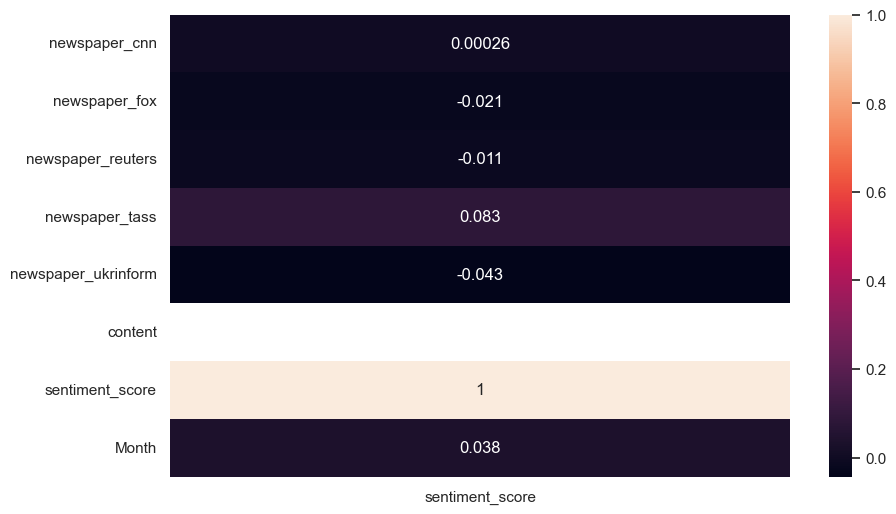

In [209]:
# Convert object series to float series to compute correlation matrix
for col in ohe_sent_articles.columns:
    if(col != "publish_date"):
        ohe_sent_articles[col] = pd.to_numeric(ohe_sent_articles[col], errors='coerce')

corr = ohe_sent_articles.corr()

plt.figure(figsize=(10,6)) 
sns.heatmap(corr[['sentiment_score']], annot=True)

It's apparent that the sentiment score alone isn't a strong indicator of which newspaper or month the article comes from, although we can see that both Ukrinform and TASS are more strongly correlated than the other newspapers as the above plots suggested.

This being said, in order to better classify each article we need to investigate the usage of certain words themselves.

## Word Analysis ##

We begin by identifying which unigrams and bigrams are most useful in identifying which article belongs to which newspaper.  This can be done by first plotting the most frequent words for each newspaper.  If we find a lot of overlap, we can concatenate the articles from each newspaper into a single text and then using TF-IDF to indentify the key words in each text conglomerate.  The power of using TF-IDF is that the score for a word in a particular newspaper is higher if it's not as present in the other newspapers' articles.

In [254]:
# Split articles into tokens again to look at frequency of ocuurance
split_articles = articles.copy()
split_articles['content'] = split_articles['content'].map(lambda x: x.split())

In [212]:
all_words = pd.Series(reduce(lambda x, y: x+y, articles['content']))
all_words_freq = pd.Series(all_words[0].split()).value_counts()[:10]


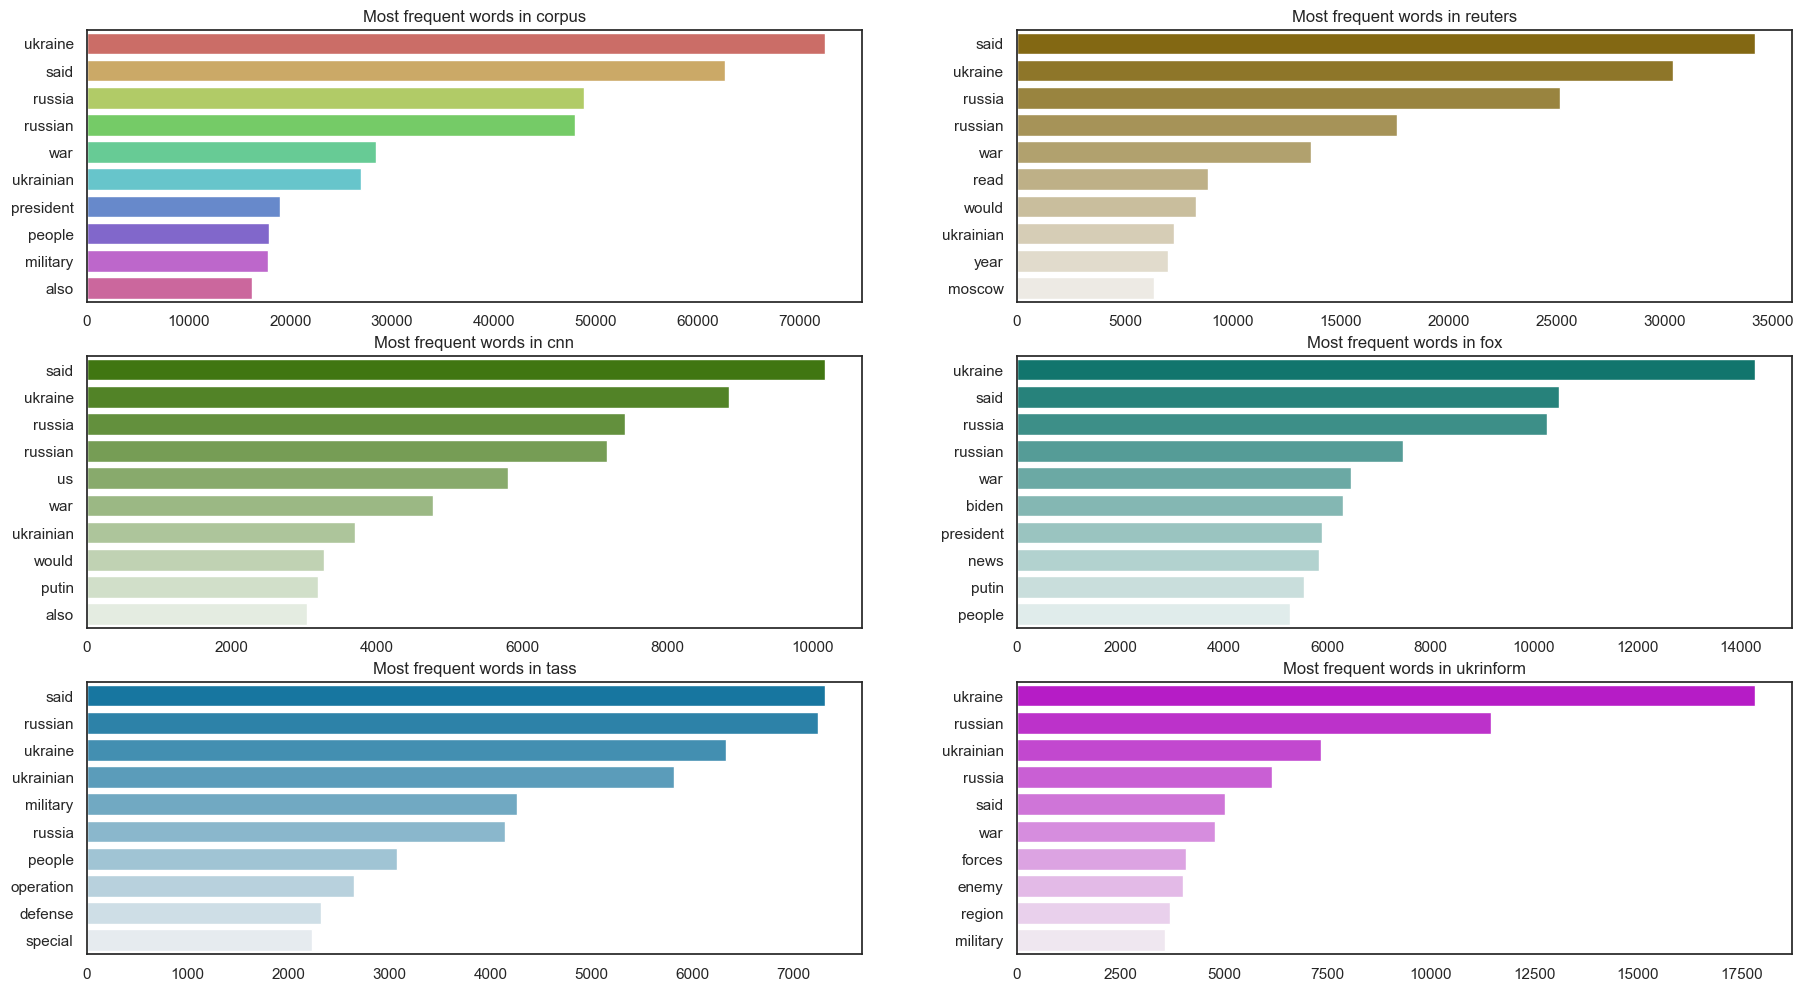

In [305]:
 #, palette=reversed(sns.color_palette('RdPu', 10)))
fig, axes = plt.subplots(3, 2, figsize=(22,12))
axes = axes.flatten()

palette = sns.diverging_palette(200, 20, s=100, l=50, sep=1, n=20, as_cmap=False)[:10]
sns.barplot(x=all_words_freq.values, y=all_words_freq.index, ax=axes[0], palette=sns.color_palette("hls", 10))
axes[0].set_title(f'Most frequent words in corpus')
for ind, newspaper in enumerate(articles['newspaper'].unique()):
    newspaper_words = pd.Series(reduce(lambda x, y: x+y, articles[articles['newspaper'] == newspaper]['content']))
    newspaper_words_freq = pd.Series(newspaper_words[0].split()).value_counts()[:10]
    palette = sns.diverging_palette(((ind+1)*60), 20, s=100, l=50, sep=1, n=20, as_cmap=False)[:10]
    sns.barplot(x=newspaper_words_freq.values, y=newspaper_words_freq.index, ax=axes[ind+1], palette=palette)
    axes[ind+1].set_title(f'Most frequent words in {newspaper}')

These plots tell us that the most frequent words in each newspaper are nearly the **same** since they are all on the same topic.

Thus, we must use TF-IDF scores to gain deeper insights into each newspaper's unique verbiage.

### Class TF-IDF ###

When researching techniques to gain insight into the differences between classes, I came upon an article by Maarten Grootendorst that modified the original TF-IDF formula to allow analysis of a class specific text conglomerate formed by joining together each class text into one long document.  The details can be found at this repo: https://github.com/MaartenGr/cTFIDF

The main idea is that the original TF-IDF weighs the IDF score is proportional to log(number of documents) and so is useful for differentiating individual documents in a dataset of many documents.  However, when trying to differentiate newspapers, or classes of documents, we cannot use individual documents but rather a collection of documents formed by joining each individual document by class.  We could just treat each collection of documents as one document, but the IDF part of TF-IDF will lose all of its power and you will find many repeats between classes.

c-TF-IDF treats this problem by calculating the IDF based on the number of documents pre-joining divided by the sum of the frequency of each word across all classes.

Below, we apply this technique to calculate the keywords that best uniquely represent the 5 newspapers in our data.

In [69]:
# First we unify each newspaper's articles into a single text using a utility function defined in the accompanying script.
unified_articles = prep.unify_text_by_newspaper(articles)


In [276]:
# Defined Tfidf vectorizer and get keywords which are stored in a new dataframe under the Series 'keywords'
# Create bag of words
count_vectorizer = CountVectorizer.fit(unified_articles['content'])
count = count_vectorizer.transform(unified_articles['content'])
words = count_vectorizer.get_feature_names()

ctfidf = prep.CTFIDFVectorizer().fit_transform(count, n_samples=len(articles)).toarray()
words_per_class = {newspaper: [words[index] for index in ctfidf[ind].argsort()[-10:]] for ind, newspaper in enumerate(unified_articles['newspaper'])}
for newspaper in unified_articles['newspaper']:
    print(f'The keywords of {newspaper} are {words_per_class[newspaper]}')


c:\Users\ajc34\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The keywords of reuters are ['prices', 'markets', 'march', 'defence', 'inflation', 'billion', 'feb', 'bank', 'zelenskiy', 'read']
The keywords of cnn are ['still', 'zelensky', 'iran', 'many', 'even', 'officials', 'getty images', 'getty', 'us', 'images']
The keywords of fox are ['going', 'know', 'news', 'get', 'zelenskyy', 'app', 'news app', 'get news', 'click get', 'click']
The keywords of tass are ['donbass republics', 'dpr', 'military operation', 'operation', 'lugansk', 'special military', 'zaporozhye', 'donbass', 'republics', 'kiev']
The keywords of ukrinform are ['scale', 'noted', 'armed', 'zelensky', 'armed forces', 'forces ukraine', 'direction', 'invaders', 'reports', 'enemy']


**Observations:**

The keywords for some newspapers turn out to be words that weren't actually in the main text but scraped from the background.  Furthermore, we see different spellings of some keywords so we need to apply stemming and remove the unwanted words from the texts before we analyze the keywords again.

It is also necessary to remove a number of bigrams that were found from using the original TFIDFVectorizer so those are also included in the cleaning function.

In [73]:
import Preprocessing_and_utility as prep
importlib.reload(prep)
# Make a copy to clean
cleaned_articles = articles.copy()
#cleaned_articles['content'] = cleaned_articles['content'].map(lambda x: x.split())

for ind in cleaned_articles.index:
    cleaned_articles.loc[ind, 'content'] = prep.remove_unwanted_unigrams_bigrams(cleaned_articles.loc[ind, 'content'].split())
    cleaned_articles.loc[ind, 'content'] = prep.nltk_stemmer(cleaned_articles.loc[ind, 'content'])




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
cleaned_articles['content'] = cleaned_articles['content'].map(lambda x: ' '.join(x))

unified_articles = prep.unify_text_by_newspaper(cleaned_articles)
# Added this extra line since without it I was getting an error
CV = CountVectorizer()
count_vectorizer = CV.fit(unified_articles['content'])
count = count_vectorizer.transform(unified_articles['content'])
words = count_vectorizer.get_feature_names()

unigram_ctfidf = prep.CTFIDFVectorizer().fit_transform(count, n_samples=len(articles)).toarray()
words_per_class = {newspaper: [words[index] for index in unigram_ctfidf[ind].argsort()[-10:]] for ind, newspaper in enumerate(unified_articles['newspaper'])}
for newspaper in unified_articles['newspaper']:
    print(f'The keywords of {newspaper} are {words_per_class[newspaper]}')

The keywords of reuters are ['export', 'billion', 'inflat', 'expect', 'defenc', 'feb', 'euro', 'rate', 'market', 'bank']
The keywords of cnn are ['come', 'offici', 'iran', 'recent', 'saudi', 'mani', 'even', 'famili', 'polit', 'us']
The keywords of fox are ['america', 'ye', 'go', 'thing', 'news', 'trump', 'think', 'american', 'get', 'know']
The keywords of tass are ['lpr', 'donetsk', 'special', 'spokesman', 'mizintsev', 'dpr', 'lugansk', 'zaporozhy', 'donbass', 'republ']
The keywords of ukrinform are ['arm', 'infrastructur', 'shell', 'scale', 'correspond', 'artilleri', 'destroy', 'occupi', 'direct', 'enemi']


c:\Users\ajc34\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Observations:**

**Reuters:** Tends to have economic-focused articles.  It's possible that many articles scraped didn't particularly pertain to the Ukraine war despite the filtering out articles that didn't mention Ukraine or Russia. 

**CNN:**  The terms 'China', 'Iran', 'house' being keywords indicates that CNN, more so than other newspapers, writes articles that are more focused on the global impact of the war rather than the main conflict.

**Fox:** Clearly indicates a focus on how the war is affecting The United States.  Trump also makes it onto the list purely due to his eminimence in GOP politics.

**TASS:** Some key words show bias towards the Russian side as both "Donbass" and "Lugansk" are regions in Ukraine where Russian separitist groups are in charge.  Zaporozhye was also captured by Russia in the beginning of the war.

**Ukrinform:** The words "occupied" and "enemy" are obvious indications of being biased towards Ukraine.  The articles are definitely focused on just the local aspect of the conflict so we see words like "infrastructure" and "artillery" as being important.


It is also interesting to see which bigrams are key in differentiating newspapers.

In [75]:
# Sets up an analysis on purely bigrams
CV = CountVectorizer(ngram_range=(2,2))
count_vectorizer = CV.fit(unified_articles['content'])
count = count_vectorizer.transform(unified_articles['content'])
bigrams = count_vectorizer.get_feature_names()

bigram_ctfidf = prep.CTFIDFVectorizer().fit_transform(count, n_samples=len(articles)).toarray()
bigrams_per_class = {newspaper: [bigrams[index] for index in bigram_ctfidf[ind].argsort()[-10:]] for ind, newspaper in enumerate(unified_articles['newspaper'])}
for newspaper in unified_articles['newspaper']:
    print(f'The key bigrams of {newspaper} are {bigrams_per_class[newspaper]}')
        

The key bigrams of reuters are ['last week', 'prime minist', 'offici said', 'interest rate', 'european union', 'unit state', 'war ukrain', 'invas ukrain', 'central bank', 'russia invas']
The key bigrams of cnn are ['year old', 'war ukrain', 'russia invas', 'russian forc', 'offici said', 'social media', 'saudi arabia', 'last week', 'white hous', 'us offici']
The key bigrams of fox are ['ga price', 'associ press', 'vladimir putin', 'unit state', 'russia invad', 'invad ukrain', 'joe biden', 'biden administr', 'white hous', 'presid biden']
The key bigrams of tass are ['russian defens', 'donetsk peopl', 'oper ukrain', 'donetsk lugansk', 'lugansk peopl', 'defens ministri', 'donbass republ', 'militari oper', 'special militari', 'peopl republ']
The key bigrams of ukrinform are ['statement made', 'relev statement', 'scale invas', 'russian invad', 'russian feder', 'full scale', 'russian troop', 'correspond report', 'arm forc', 'forc ukrain']


Although the story is similar to the unigrams, we can make a few additional observations:

**1.** Most newspapers describe a "russian invasion" while TASS uses the phrase "military operation".

**2.** Fox mentions the Biden administration a lot, likely criticizing its response to the crisis.  Also, Fox has put more focus on gas prices and its impact on ordinary citizens, whereas CNN mentions Saudia Arabia, a major oil exporting country.

We can also plot the c-TF-IDF scores to see which key words are more important than others.

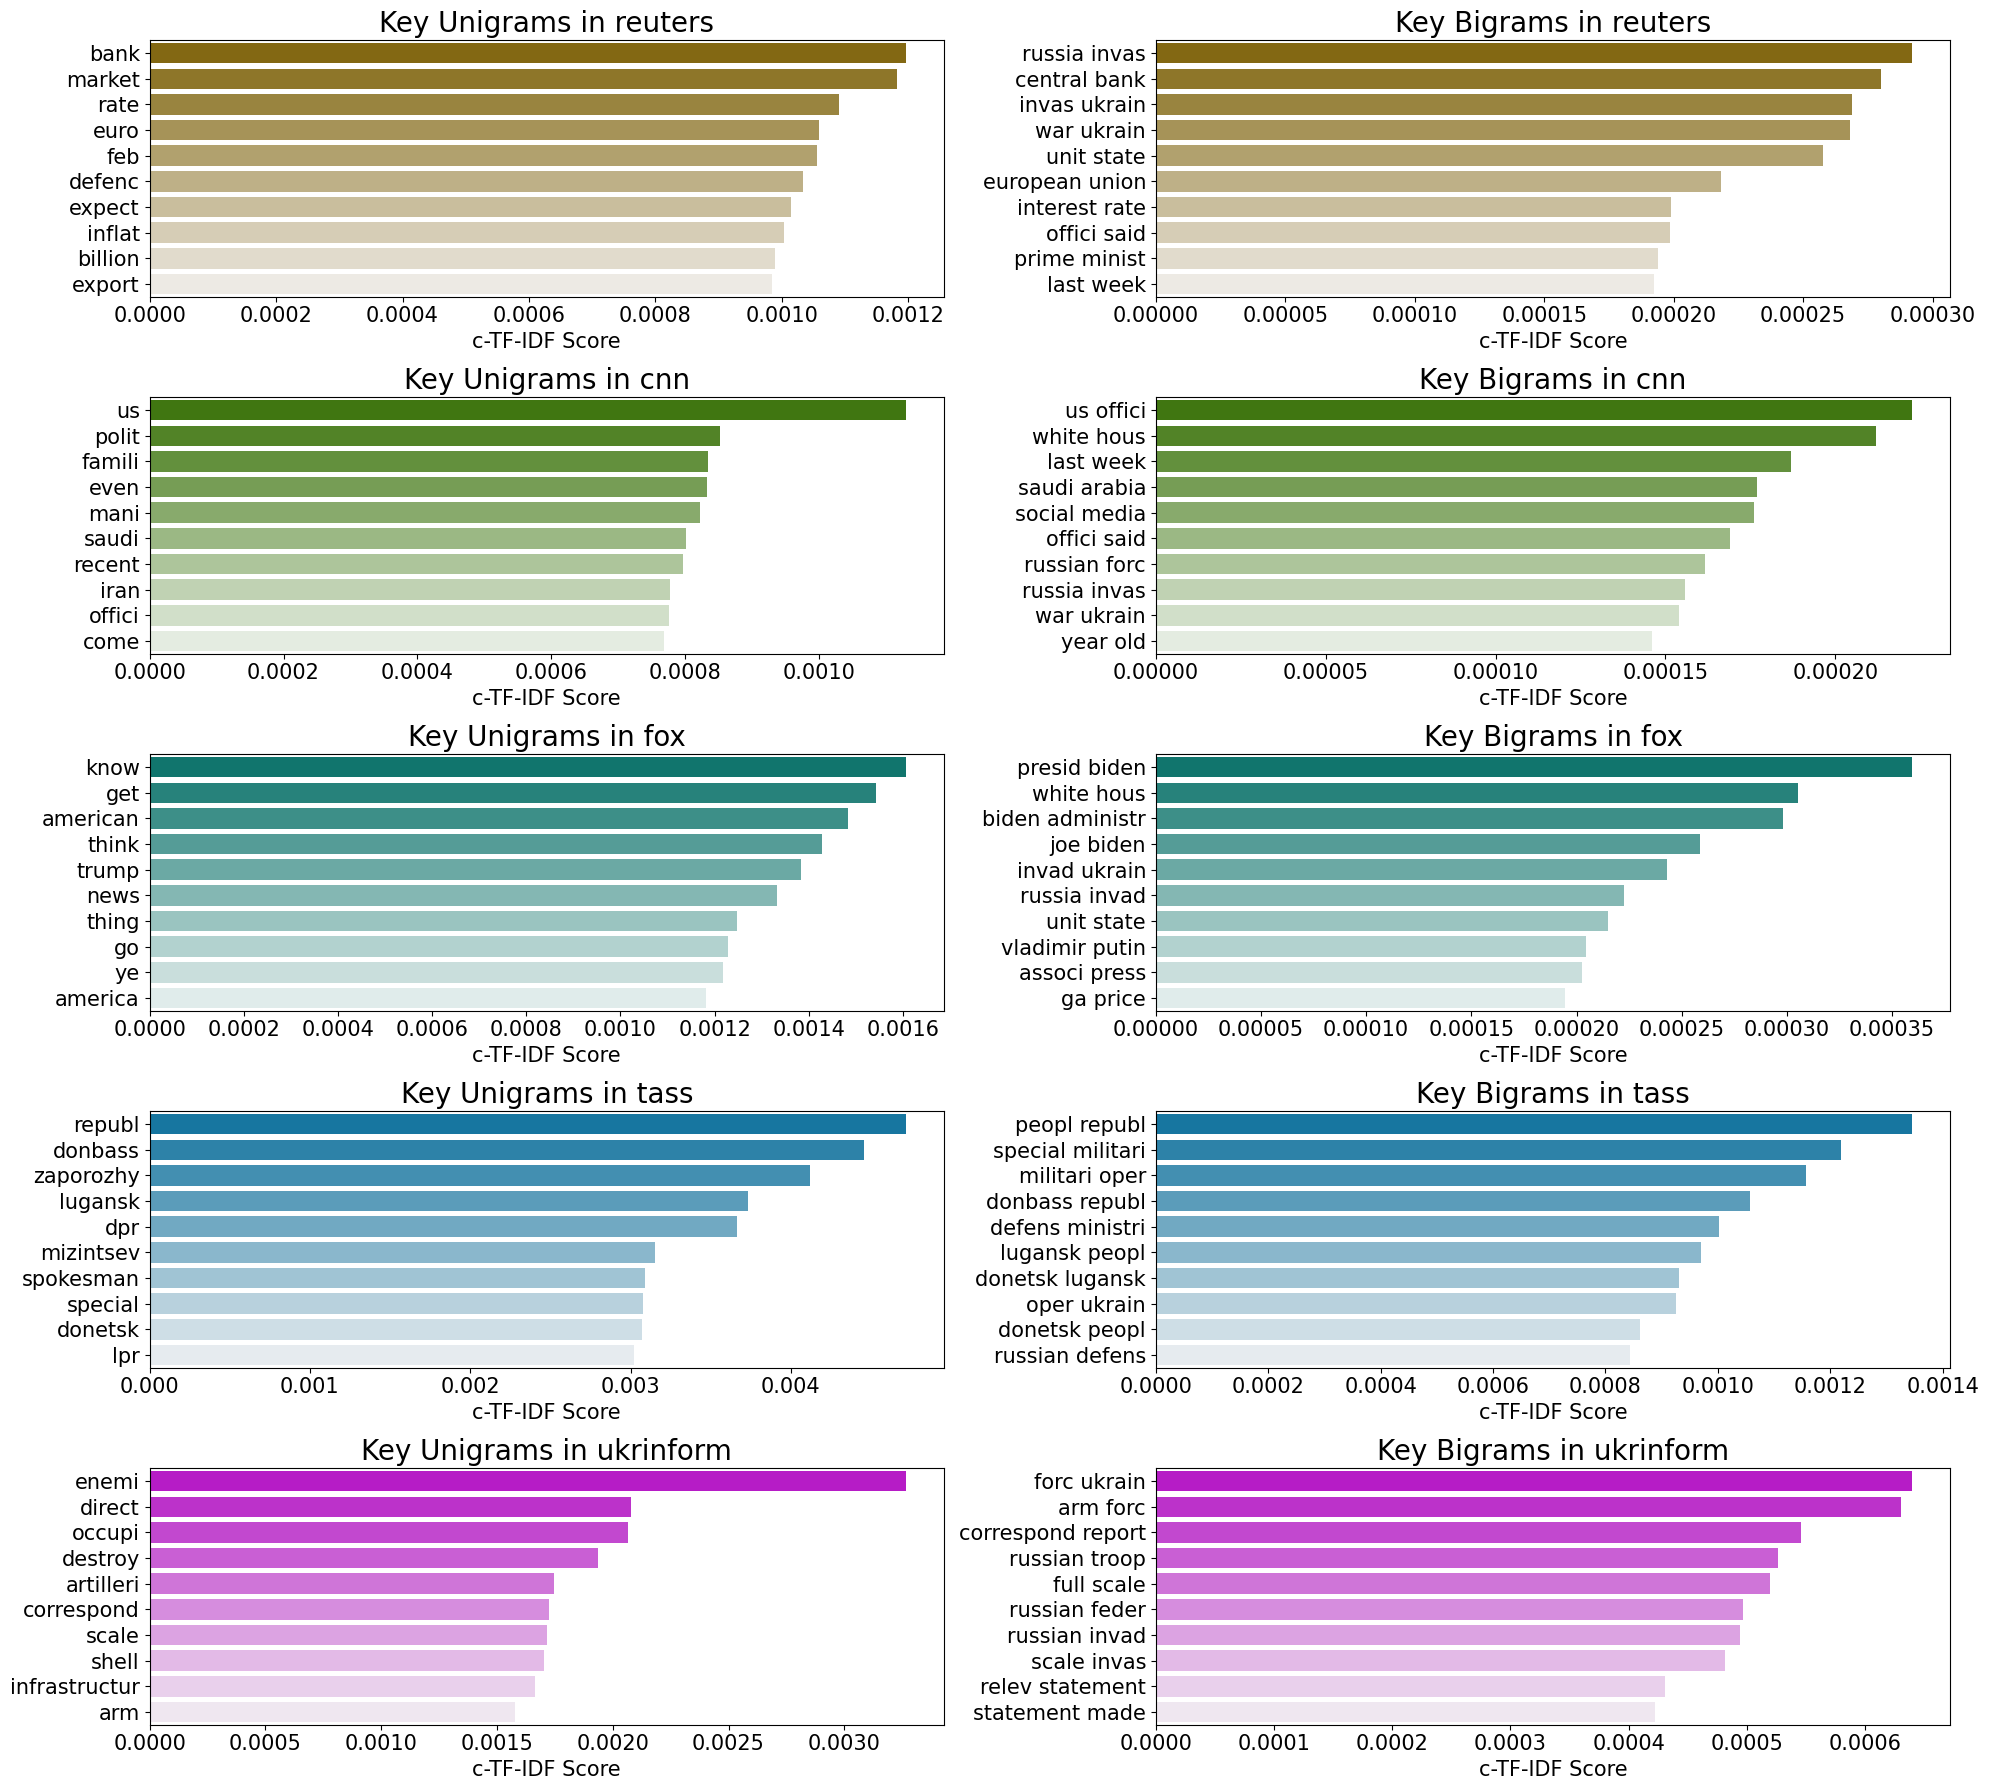

In [76]:
fig, axes = plt.subplots(5, 2, figsize=(20,18))
axes = axes.flatten()

palette = sns.diverging_palette(200, 20, s=100, l=50, sep=1, n=20, as_cmap=False)[:10]
for ind, newspaper in enumerate(articles['newspaper'].unique()):
    
    unigram_x = unigram_ctfidf[ind][unigram_ctfidf[ind].argsort()[-10:]][::-1]
    bigram_x = bigram_ctfidf[ind][bigram_ctfidf[ind].argsort()[-10:]][::-1]
    
    palette = sns.diverging_palette(((ind+1)*60), 20, s=100, l=50, sep=1, n=20, as_cmap=False)[:10]
    sns.barplot(x=unigram_x, y=words_per_class[newspaper][::-1], ax=axes[ind*2], palette=palette)
    sns.barplot(x=bigram_x, y=bigrams_per_class[newspaper][::-1], ax=axes[ind*2+1], palette=palette)

    axes[ind*2].set_title(f'Key Unigrams in {newspaper}', {'fontsize': 20})
    axes[ind*2+1].set_title(f'Key Bigrams in {newspaper}', {'fontsize': 20})
for ax in axes:
    ax.set_xlabel('c-TF-IDF Score', {'fontsize': 15})
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    #ax.set_yticklabels({'fontsize': 20})
plt.tight_layout()

**Observations:**

**1.**  None of the CTFIDF scores are particularly high which could mean accurately classifying a text as belonging to one of the newspapers could be difficult.

**2.** The most important uni/bigrams for CNN and Fox are US focused.  "Biden" and similar bigrams being the most important for Fox reinforces the idea that Fox loves to criticize the Biden administration.

**3.** Expectedly, "Enemy" is the most important for Ukrinform.

**4.** "Kiev" is most key for TASS since Russia wants to focus on attacking/taking Ukraine's capital.  "People's Republic" is also important since it refers to the Luhansk People's Republic, created by Russian-backed separatists in eastern Ukraine.

**5.** Reuters still has a strong focus on economy.

## Modeling ##

### c-TF-IDF ###
We first see if using the c-TF-IDF scores can work as a semi-supervised model.  We split the data into a training and validation set and calculate their c-TF-IDF vectors and see how similar they are.  

In [19]:
label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(cleaned_articles['newspaper'].values)

# Split training 
#X_train, X_test, y_train, y_test = train_test_split(cleaned_articles['content'], y, stratify=y, random_state=42, test_size=0.1, shuffle=True)
X_train, X_test = train_test_split(cleaned_articles, random_state=42, test_size=0.1, shuffle=True)
X_train_unified = prep.unify_text_by_newspaper(X_train)


# Include both unigrams and bigrams and create c-TF-IDF based on the training data
CV = CountVectorizer(ngram_range=(1,2))
count_vectorizer = CV.fit(X_train_unified['content'])
count = count_vectorizer.transform(X_train_unified['content'])
ctfidf_vectorizer = prep.CTFIDFVectorizer().fit(count, n_samples=len(X_train))
train_ctfidf = ctfidf_vectorizer.transform(count)

# Create a vector based on test data and compare with train data vector.
count = count_vectorizer.transform(X_test['content'])
test_ctfidf = ctfidf_vectorizer.transform(count)

similarity = cosine_similarity(test_ctfidf, train_ctfidf)
prediction = np.argmax(similarity, 1)


In [20]:
# Label encode newspaper labels
y_test = label_encoder.fit_transform(X_test['newspaper'])
print(metrics.classification_report(y_test, prediction, target_names=['cnn', 'fox', 'reuters', 'tass', 'ukrinform']) )#, target_names=)


              precision    recall  f1-score   support

         cnn       0.47      0.71      0.57       144
         fox       0.03      0.05      0.04       240
     reuters       0.84      0.89      0.86       689
        tass       0.99      0.86      0.92       320
   ukrinform       0.06      0.03      0.04       394

    accuracy                           0.57      1787
   macro avg       0.48      0.51      0.49      1787
weighted avg       0.55      0.57      0.56      1787



We obtain an overall accuracy of 57% but we can see the model had a very difficult time predicting both Fox and Ukrinform.  Let's look at the confusion matrix and see what Fox and Ukrinform articles are being predicted as.

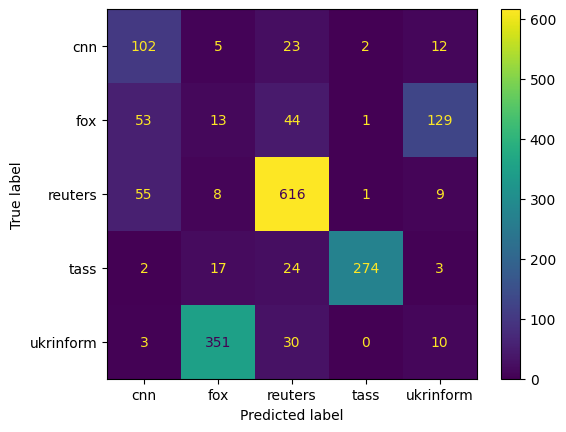

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay


conf = confusion_matrix(y_test, prediction) #, labels=['cnn', 'fox', 'reuters', 'tass', 'ukrinform'])
#plt.figure(figsize=(10,6)) 
#sns.heatmap(conf, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['cnn', 'fox', 'reuters', 'tass', 'ukrinform'])
disp.plot()

The model seems to particularly confuse articles from Fox and Ukrinform.  It's not clear why this is since the key words seemed to be much different.  Let's now try to fit to the regular TFIDF scores and see if this problem persists.

### XGBoost: TF-IDF plus other features ###

Here we train XGBoost on the TF-IDF scores and see if including the sentiment score and month as a feature will help classifying.

#### TF-IDF alone ####

In [11]:
# Label encode newspaper names
label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(cleaned_articles['newspaper'].values)
# Use sublinear_tf since we have a wide range of document lengths
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.7, use_idf=True, ngram_range=(1, 2), max_features=50000)

X = tfidf.fit_transform(cleaned_articles['content'])

# Split training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajc34\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\ajc34\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
              precision    recall  f1-score   support

         cnn       0.89      0.69      0.78       142
         fox       0.93      0.93      0.93       237
     reuters       0.94      0.99      0.97       689
        tass       0.96      0.97      0.96       292
   ukrinform       0.96      0.95      0.96       427

    accuracy                           0.95      1787
   macro avg       0.94      0.91      0.92      1787
weighted avg       0.95      0.95      0.94      1787



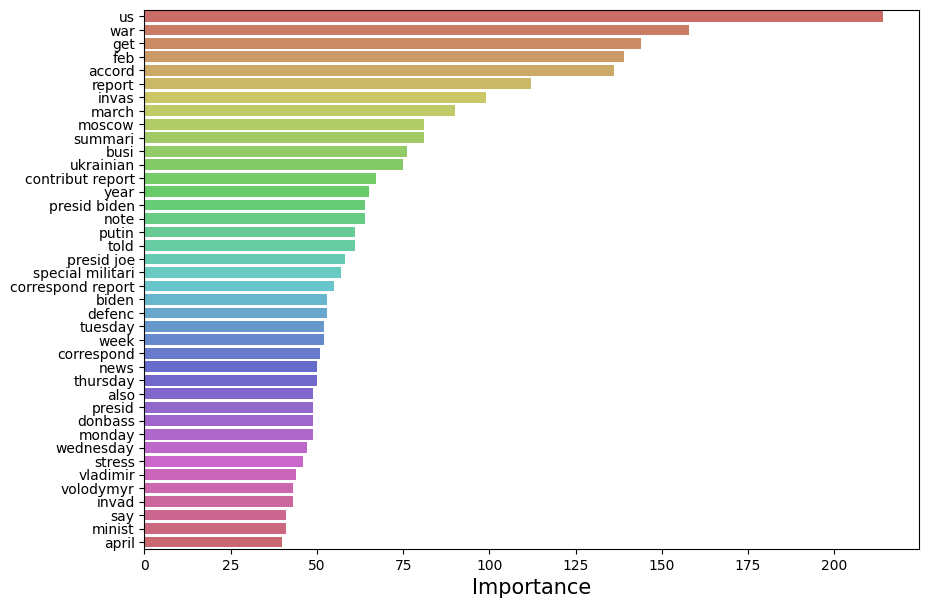

In [23]:
import Preprocessing_and_utility as prep
importlib.reload(prep)
# Using parameters 
xgboost1 = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005, objective='multi:softprob')

#Fit the algorithm on the data
prep.xgboost_fit_evaluate(xgboost1, X_train, y_train, X_test, y_test)
#Get words to plot important features
words = tfidf.get_feature_names_out()
prep.xgboost_plot_importance(xgboost1, 40, words)


**Model Accuracy**

The model performs very well with an overall 95% accuracy but we should question how we got such a great performance by first looking at important features.

**Important Features**

The important features correspond decently well with the keywords obtaining with the c-TFIDF scores.
A few points:
 
* We see a number of "days of the week" appear which seem to mainly feature in Reuters.
* The word invade should appear in Ukrinform more than the other newspapers.
* Biden was previously noted as being particular to Fox

All of the important features look like words used in the real article so the accuracy of our model is based on the actual text as opposed to background text.

#### TF-IDF and Sentiment Score ####

Our strategy is to pass in a sparse matrix with TF-IDF scores along with the sentiment scores so if we use 50000 features in our TfidfVectorizer, we should pass in 500001 features.

Since sentiment score wasn't highly correlated with any of the newspapers we don't expect this to impact the accuracy much but if it increased the accuracy by only 1% it is worth including since it's only one feature out of 50001.

In [12]:
# Get TF-IDF values
X_tfidf = tfidf.fit_transform(cleaned_articles['content'])


In [ ]:
# Get sentiment scores for cleaned articles
cleaned_articles = prep.get_sentiment_score(cleaned_articles)

In [43]:
# Concatenate sentiment score with TF-IDF
# First get list of sentiment scores
X_sent = list(cleaned_articles['sentiment_score'])
# Convert to 2D array
X_sent_shaped = [X_sent[i:i+1] for i in range(0, len(X_sent), 1)]
# Convert to sparse matrix
X_sent_sparse = sparse.csr_matrix(X_sent_shaped)
# Stack TF-IDF scores with sentiment scores horizontally
X = sparse.hstack([X_tfidf, X_sent_sparse])


In [46]:
# Confirm we have the right shape
print(X.shape)

(17862, 50001)


In [47]:
# Split training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

In [49]:
# Using parameters 
xgboost1 = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005, objective='multi:softprob')

#Fit the algorithm on the data
prep.xgboost_fit_evaluate(xgboost1, X_train, y_train, X_test, y_test)


c:\Users\ajc34\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
              precision    recall  f1-score   support

         cnn       0.89      0.70      0.79       142
         fox       0.92      0.93      0.93       237
     reuters       0.95      0.99      0.97       689
        tass       0.96      0.97      0.96       292
   ukrinform       0.96      0.95      0.96       427

    accuracy                           0.95      1787
   macro avg       0.94      0.91      0.92      1787
weighted avg       0.95      0.95      0.94      1787



The accuracy doesn't change at all, although we get a small improvement in the recall and f1-score for CNN.

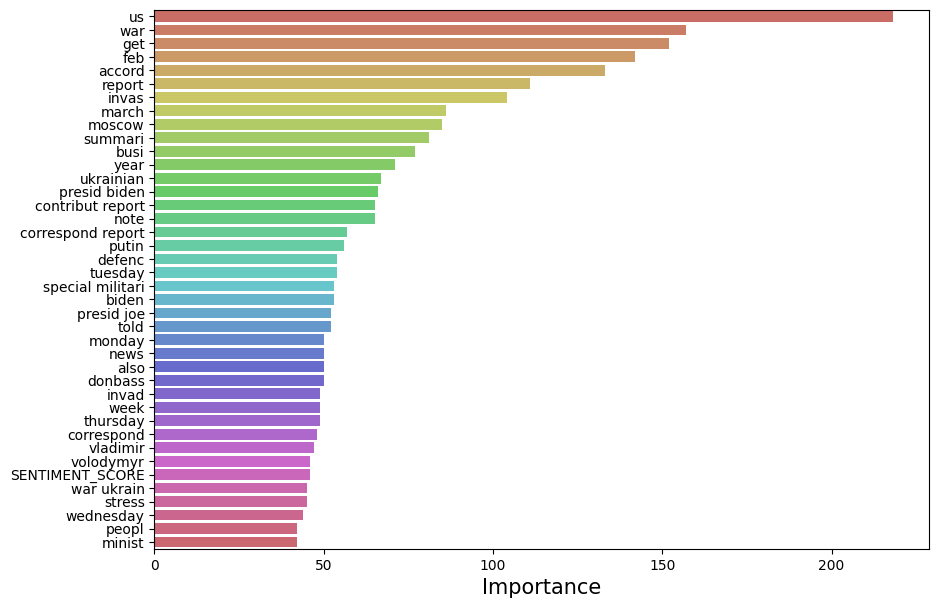

In [60]:

#Get words to plot important features
words = tfidf.get_feature_names_out()
words_and_sentiment = np.append(words, np.array('SENTIMENT_SCORE'))
prep.xgboost_plot_importance(xgboost1, 40, words_and_sentiment)

Sentiment score makes it into the top 40 most important features but it is not the most important feature despite it containing much more textual information than any one word does.

However, due to its immense variance taken across all months we can't expect it to help much in classifying newspapers which is proven by its low correlation with newspapers in the previous setion.

### Neural Network ###

Although we could try to improve the accuracy of the XGBoost model by optimizing hyperparameters and including more features from TFIDF, the accuracy is high enough that the improvement would be relatively small.

Instead, we try to compare the accuracy to a simple dense neural network to see which performs better.

In [56]:
# One hot encode to use "categorical_crossentropy" as loss function in neural net
ohe_encoder = preprocessing.OneHotEncoder()

y = ohe_encoder.fit_transform(cleaned_articles['newspaper'].values.reshape(-1, 1))
y = y.toarray()

# Split training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

# Sort indices for data generator
X_train.sort_indices()
X_test.sort_indices()

In [67]:
# Create a simple sequential dense neural network.  We add dropout to avoid overfitting and batch normalization to reduce vanishing/exploding gradient problem.

# To deal with the immense data of TF-IDF, we want to keep it as a sparse matrix but neural networks don't accept sparse matrices.  Instead, we feed in small batches of dense matrices
# using a custom data generator
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=50000))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(prep.DataGenerator(X_train, y_train, 32, (17862, 50000)), epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
502/502 [==============================] - 49s 95ms/step - loss: 0.3063 - accuracy: 0.8988 - val_loss: 0.2326 - val_accuracy: 0.9407
Epoch 2/5
502/502 [==============================] - 57s 114ms/step - loss: 0.0472 - accuracy: 0.9869 - val_loss: 0.1382 - val_accuracy: 0.9603
Epoch 3/5
502/502 [==============================] - 56s 112ms/step - loss: 0.0172 - accuracy: 0.9960 - val_loss: 0.1466 - val_accuracy: 0.9608
Epoch 4/5
502/502 [==============================] - 55s 110ms/step - loss: 0.0114 - accuracy: 0.9974 - val_loss: 0.1562 - val_accuracy: 0.9586
Epoch 5/5
502/502 [==============================] - 64s 127ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.1640 - val_accuracy: 0.9586


We see at epoch 3 we get the highest accuracy of 0.9608 which is slightly better than what we got with XGBoost.  Because the training accuracy is so much better, we could be suffering from slight overfitting.

For the next model we make two changes:
1. Replace ReLu with SeLU to avoid the dead ReLU issue.
2. Slightly increase the percentage of dropout per layer

In [68]:
model = Sequential()
model.add(Dense(200, activation='selu', input_dim=50000))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

model.add(Dense(200, activation='selu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(prep.DataGenerator(X_train, y_train, 32, (17862, 50000)), epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
502/502 [==============================] - 50s 98ms/step - loss: 0.2840 - accuracy: 0.9052 - val_loss: 0.1460 - val_accuracy: 0.9558
Epoch 2/5
502/502 [==============================] - 60s 119ms/step - loss: 0.0449 - accuracy: 0.9882 - val_loss: 0.1416 - val_accuracy: 0.9614
Epoch 3/5
502/502 [==============================] - 57s 114ms/step - loss: 0.0206 - accuracy: 0.9956 - val_loss: 0.1466 - val_accuracy: 0.9642
Epoch 4/5
502/502 [==============================] - 56s 112ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.1623 - val_accuracy: 0.9575
Epoch 5/5
502/502 [==============================] - 56s 112ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.1780 - val_accuracy: 0.9541


We get marginal improvement on the validation accuracy on epoch 3.

## Conclusion ##

### Key insights ###

**1.** Text sentiment over time decreased for TASS but increased for Ukrinform, reflecting the state of the conflict.  CNN, Fox, and Reuters have a larger variation in sentiment but seem to increase over time

**2.** Key unigrams and bigrams were uncovered using [c-TF-IDF](https://github.com/MaartenGr/cTFIDF) that clearly distinguished the reporting of each newspaper.

**3.** Both XGBoost and the DNN had an excellent validation accuracy, although the DNN performed marginally better.

### Potential issues ###

**1.** In the process of scraping content from newspaper articles, we could have scraped background text which is specific to the formatting of that newspaper.  Although this was cleaned up, it's possible some still remained and could explain the high accuracy of the models.

**2.** Sentiment analysis relied on VADER which is a model trained on social media posts as opposed to articles.  With a better model, it's possible to see less variation in sentiment.